# Application of mdi-PLS for domain adaptation
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___
First we load some modules that we will be using including the GCT-PLS class.

In [19]:
!pip install pandas; seaborn
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.io as sio
import matplotlib.pyplot as plt

from diPLSlib.models import GCTPLS as gctpls
from diPLSlib import functions as fct
plt.style.use('ggplot')

### Data Set

We will use the Corn data set from Eigenvector Research Inc. The data set contains NIR spectra of corn samples from two different instruments. The data set is available at https://www.eigenvector.com/data/Corn/. The data set is also available in the `data` folder of this repository. 

In [20]:
data = sio.loadmat('../data/corn.mat')

# Spectra
m5 = data['m5spec'][0][0]['data']
mp5 = data['mp5spec'][0][0]['data']
mp6 = data['mp6spec'][0][0]['data']
wn = data['m5spec'][0][0][9][1][0][0]

SPEC = {'m5': m5, 'mp5': mp5, 'mp6': mp6}

# Properties
Y = data['propvals']['data'][0][0]
y = np.expand_dims(Y[:,0],1) # 0: Moisture, 1: Oil, 2: Protein, 3: Starch

We split the m5 and mp6 spectra into a training and test set. We will use the m5 spectra along with the moisture contents for calibration, the NIST standard samples form the m5 and mp6 instruments for instrument standardization, and the mp6 test set for evaluation.

In [21]:
idx_train = np.random.choice(np.arange(0,80,1), 60, replace=False)
idx_test = np.delete(np.arange(0,80,1), idx_train)

m5_train = m5[idx_train,:]
m5_test = m5[idx_test,:]
mp6_test  = mp6[idx_test,:]
y_train = y[idx_train] 
y_test = y[idx_test]

# Transfer Standards
m5nbs = data['m5nbs'][0][0]['data']
mp5nbs = data['mp5nbs'][0][0]['data']
mp6nbs = data['mp6nbs'][0][0]['data']
mp5nbs = np.delete(mp5nbs,0,0)
mp6nbs = np.delete(mp6nbs,0,0)

NBS = {'m5nbs': m5nbs, 'mp5nbs': mp5nbs, 'mp6nbs': mp6nbs}

d = pd.DataFrame({'wn': wn, 'm5': np.mean(m5,0), 'mp6': np.mean(mp6,0), 'm5_NIST': np.mean(m5nbs,0), 'mp6_NIST': np.mean(mp6nbs,0)})

Let's take a look at the mean spectra of the corn samples and the NIST transfer standards from the two instruments.

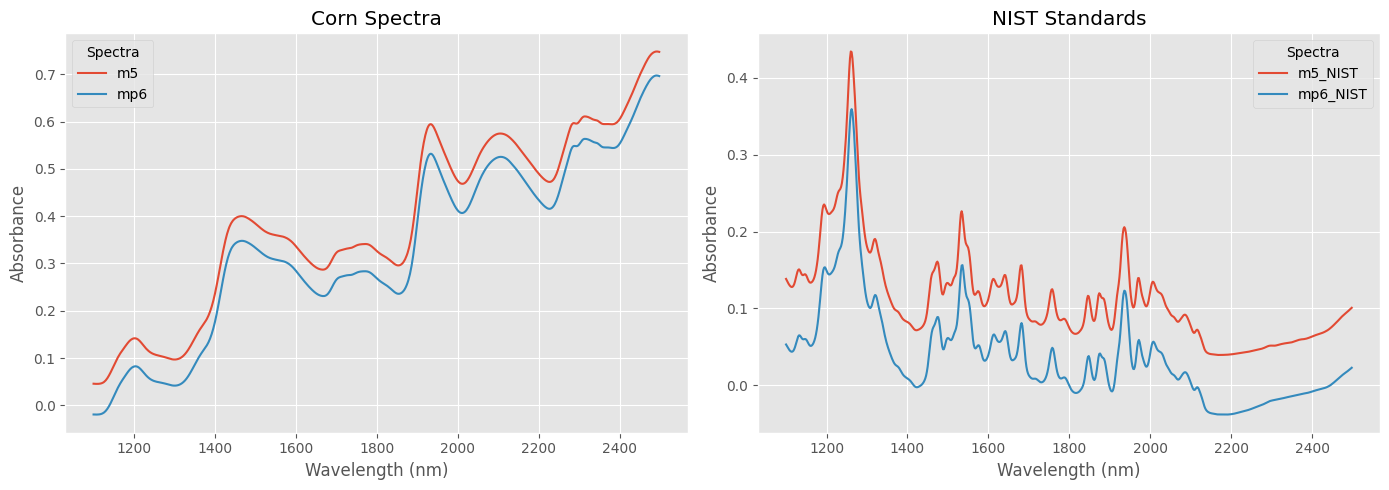

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
dd = pd.melt(d, id_vars='wn', value_vars=['m5','mp6'], var_name='Spectra', value_name='Absorbance')
ax = plt.gca()
sb.lineplot(x='wn', y='Absorbance', hue='Spectra', data=dd, ax=ax).set(title='Corn Spectra')
ax.set_xlabel('Wavelength (nm)')

plt.subplot(122)
dd = pd.melt(d, id_vars='wn', value_vars=['m5_NIST','mp6_NIST'], var_name='Spectra', value_name='Absorbance')
ax = plt.gca()
sb.lineplot(x='wn', y='Absorbance', hue='Spectra', data=dd, ax=ax).set(title='NIST Standards')
ax.set_xlabel('Wavelength (nm)')

plt.tight_layout()

As can be seen, the mean spectra of the corn samples from the two instruments have a significant offset. The NIST standards have quite different spectra compared to the corn samples. 

### Graph Calibration Transfer Partial Least Squares Regression (GCT-PLS)
Using GCT-PLS we will try to use the m5 Corn spectra along with the m5 and mp6 NIST standards to find a calibration model that can be used to predict the moisture content of the corn samples from the mp6 instrument. We first explore how regularization impacts the projections of calibration and transfer standard samples.

In [23]:
ncomp = 3
l = np.array([0, 10, 100])
m = gctpls(m5_train, y_train, m5nbs, mp6nbs, ncomp)

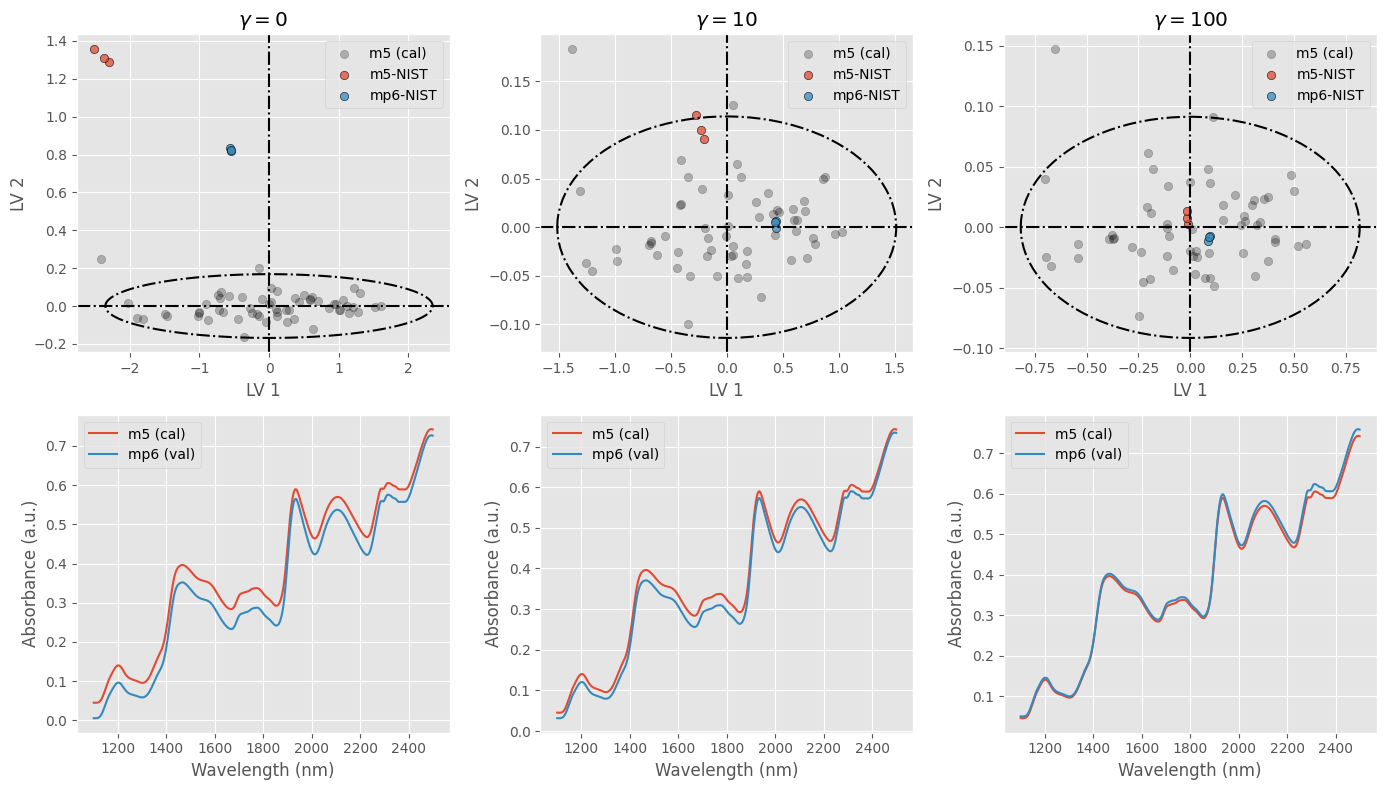

In [24]:
k = 1
plt.figure(figsize=(14, 8))
for i in l:
    m.fit([i])

    # Projection
    sub = "2"+"3"+str(k)
    plt.subplot(int(sub))
    sp = plt.scatter(m.T[:,0], m.T[:,1], color='k', edgecolors='k',alpha=0.25)
    plt.scatter(m.Ts[:,0], m.Ts[:,1], edgecolors='k',alpha=0.75)
    plt.scatter(m.Tt[:,0], m.Tt[:,1], edgecolors='k',alpha=0.75)   
    plt.legend(['m5 (cal)','m5-NIST','mp6-NIST'])
    el = fct.hellipse(m.T)
    plt.plot(el[0, :], el[1, :], '-.k')
    plt.axhline(y=0,linestyle='-.', color='k')
    plt.axvline(x=0,linestyle='-.', color='k')
    plt.xlabel('LV 1')
    plt.ylabel('LV 2')
    title = '$\gamma=$' + str(i)
    plt.title(title)
    
    #Reconstruction
    sub = "2"+"3"+str(k+3)
    plt.subplot(int(sub))
    m5_hat = m.T@m.P.T + m.mu
    plt.plot(wn,np.mean(m5_hat, 0))
    mp6t = mp6_test[...,:] - m.mu
    mp6_hat = mp6t@(m.W@np.linalg.inv(m.P.T@m.W))@m.P.T + m.mu
    plt.plot(wn, np.mean(mp6_hat, 0))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend(['m5 (cal)', 'mp6 (val)'])
    k += 1

plt.tight_layout()

In the plot we can see that with increasing regularization the projections of the (matched) transfer standard samples move closer together (top plots). When reconstructing the m5 training and mp6 validation samples from the corresponding latent variables, we see that the (mean) spectra of the samples become more similar (bottom plots). We will now compare the performance of a calibration with and without regularization.

### Standard PLS model

In [25]:
ncomp = 3
L = fct.transfer_laplacian(m5nbs, mp6nbs)
m_pls = gctpls(m5_train, y_train, m5nbs, mp6nbs, ncomp)
m_pls.fit(l=[0])
yhat_pls, error_pls = m_pls.predict(mp6_test, y_test, rescale=m5_train)
print('RMSEP (PLS): ' + str(np.round(error_pls, 2)))

RMSEP (PLS): 0.37


### GCT-PLS model

In [26]:
l = [10]                                                                                   # Regularization parameter
m_gctpls = gctpls(m5_train, y_train, m5nbs, mp6nbs, ncomp)
m_gctpls.fit(l=l)
yhat_gctpls, error_gctpls = m_gctpls.predict(mp6_test, y_test, rescale=m5_train)
print('RMSEP (GCT-PLS): ' + str(np.round(error_gctpls, 2)))

RMSEP (GCT-PLS): 0.27


### Plot results

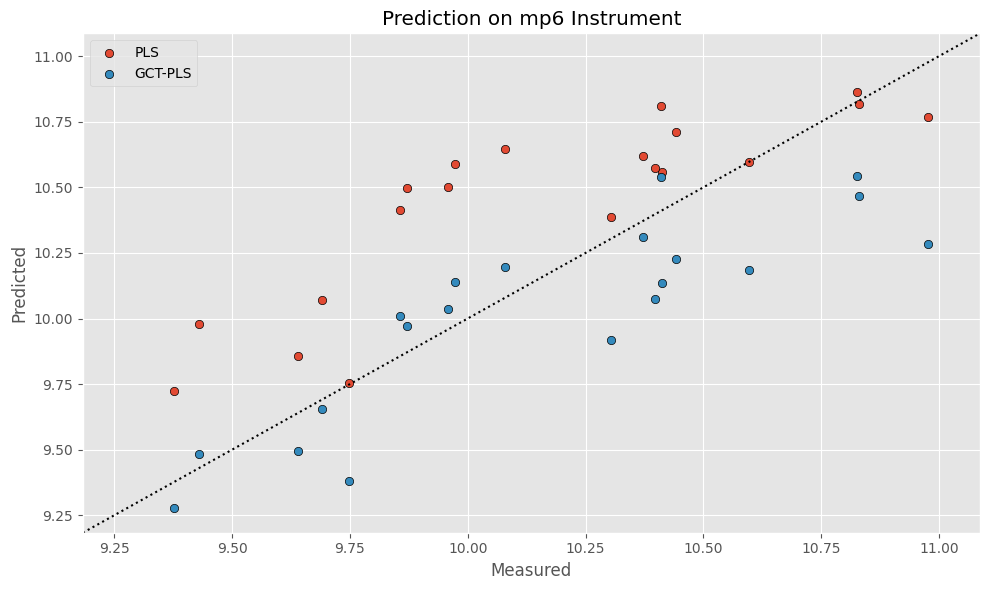

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, yhat_pls, edgecolors='k')
plt.scatter(y_test, yhat_gctpls, edgecolors='k')
plt.legend(['PLS', 'GCT-PLS'])
min_ = np.min(np.array([y_test,yhat_pls,yhat_gctpls]))*0.99
max_ = np.max(np.array([y_test,yhat_pls,yhat_gctpls]))*1.01
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Prediction on mp6 Instrument')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.tight_layout()

We can see that the GCT-PLS model (with regularization) performs better than the standard PLS model.